# Library Imports

In [1]:
import ezdxf
import matplotlib.pyplot as plt
from ezdxf.addons.drawing.matplotlib_backend import MatplotlibBackend
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.groupby import groupby
from pygcode import *

# Import DXF File and Create Image

In [2]:
def get_dxf(file_loc):
    doc = ezdxf.readfile(file_loc)
    msp = doc.modelspace()
    group = groupby(entities=msp, dxfattrib='layer')
    
    layout = doc.layouts.get('Model')
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(layout, finalize=True)
    plt.show()
    out.finalize()
    fig.savefig('Images/Outputs/dxf_output.png', dpi=600)
    
    return doc, msp, group

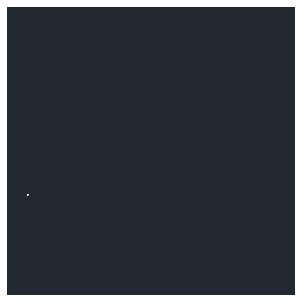

In [3]:
doc, msp, group = get_dxf("DXF/CircleMonogram11.dxf")

# Print DXF Entities

In [4]:
def print_line(e):
    print("LINE:")
    print("start point: %s" % e.dxf.start)
    print("end point: %s\n" % e.dxf.end)

In [5]:
def print_arc(e):
    print("ARC:")
    print("start point: %s" % e.start_point)
    print("end point: %s" % e.end_point)
    print("start angle: %s" % e.dxf.start_angle)
    print("end angle: %s" % e.dxf.end_angle)
    print("radius: %s\n" % e.dxf.radius)

In [6]:
def print_circle(e):
    print("Circle:")
    print("centre point: %s" % e.dxf.center)
    print("radius: %s\n" % e.dxf.radius)

In [7]:
def print_poly(e):
    print("POLYLINE:")
    print("THIS POLYLINE CONTAINS:\n")
    for entity in e.virtual_entities():
        if entity.dxftype() == 'LINE':
            print_line(entity)
        elif entity.dxftype() == 'ARC':
            print_arc(entity)
    print('-'*40)

In [8]:
def list_entities(group):
    for layer, entities in group.items():
        print(f'Layer "{layer}" contains following entities:')
        for entity in entities:
            print('    {}'.format(str(entity)))
        print('-'*40)

In [9]:
#list_entities(group)

In [10]:
def print_all_info(msp):
    for e in msp:
        if e.dxftype() == 'LINE':
            print_line(e)
        elif e.dxftype() == 'ARC':
            print_arc(e)
        elif e.dxftype() == 'CIRCLE':
            print_circle(e)
        elif e.dxftype() == 'POLYLINE':
            print_poly(e)

In [11]:
print_all_info(msp)

POLYLINE:
THIS POLYLINE CONTAINS:

ARC:
start point: (18.136084, 2.704802999999999, 0.0)
end point: (17.939188, 2.8412319999999998, 0.0)
start angle: 39.526084617844504
end angle: 71.03783231768018
radius: 0.44108400169914835

LINE:
start point: (17.939188, 2.841232, 0.0)
end point: (17.911169, 2.853195, 0.0)

LINE:
start point: (17.911169, 2.853195, 0.0)
end point: (17.882952, 2.865326, 0.0)

ARC:
start point: (17.607508, 3.1263890000000005, 0.0)
end point: (17.882952, 2.8653260000000005, 0.0)
start angle: -157.2892416983735
end angle: -109.63988187701818
radius: 0.4697536635528975

LINE:
start point: (17.607508, 3.126389, 0.0)
end point: (17.59001, 3.172104, 0.0)

LINE:
start point: (17.59001, 3.172104, 0.0)
end point: (17.579763, 3.171463, 0.0)

ARC:
start point: (17.579763, 3.1714629999999997, 0.0)
end point: (17.511839, 2.7150730000000003, 0.0)
start angle: 151.47530519606843
end angle: -168.4055634396513
radius: 0.672625423180618

ARC:
start point: (17.511839, 2.715073, 0.0)
end 

ARC:
start point: (14.302641000000001, 8.96727, 0.0)
end point: (14.034662, 9.429169, 0.0)
start angle: 19.303991697043482
end angle: 40.93787542603303
radius: 1.4227152687066762

ARC:
start point: (14.282934, 8.231689, 0.0)
end point: (14.302641, 8.96727, 0.0)
start angle: -21.198067581937604
end angle: 18.128771623931048
radius: 1.0933994352579195

ARC:
start point: (14.218194999999998, 8.08168, 0.0)
end point: (14.282934, 8.231689, 0.0)
start angle: -26.423049206360187
end angle: -20.263861043060224
radius: 1.5205958553755639

----------------------------------------
POLYLINE:
THIS POLYLINE CONTAINS:

LINE:
start point: (12.849798, 10.379288, 0.0)
end point: (12.790083, 10.369278, 0.0)

LINE:
start point: (12.790083, 10.369278, 0.0)
end point: (12.731436, 10.355972, 0.0)

LINE:
start point: (12.731436, 10.355972, 0.0)
end point: (12.67396, 10.33963, 0.0)

ARC:
start point: (12.67396, 10.339630000000001, 0.0)
end point: (12.083436999999998, 10.003006, 0.0)
start angle: 109.0162121699

# Convert Entities to GCODE

In [12]:
def line_to_gcode(e):
    x_start = e.dxf.start[0]
    y_start = e.dxf.start[1]
    x_end = e.dxf.end[0]
    y_end = e.dxf.end[1]
    gcode = [
        GCodeRapidMove(X=x_start,Y=y_start),
        GCodeLinearMove(X=x_end,Y=y_end),
    ]
    return gcode

In [13]:
def arc_to_gcode(e):
    x_start = str(e.start_point[0])
    y_start = str(e.start_point[1])
    a_start = str(e.dxf.start_angle)
    a_end = str(e.dxf.end_angle)
    radius = str(e.dxf.radius)
    gcode = [
        "G03 R " + radius + " X" + x_start + " Y" + y_start + " S" + a_start + " E" + a_end,
    ]
    return gcode

In [14]:
def circle_to_gcode(e):
    x_center = e.dxf.center[0]
    y_center = e.dxf.center[1]
    radius = e.dxf.radius
    
    x_start = x_center
    y1_start = x_center - radius
    y2_start = y_center + radius
    
    gcode = [
        GCodeRapidMove(X=x_start,Y=y1_start),
        "G03 R " + str(radius) + " X" + str(x_start) + " Y" + str(y1_start) + " S-90" +" E90",
        "G03 R " + str(radius) + " X" + str(x_start) + " Y" + str(y2_start) + " S90" +" E270",
    ]
    return gcode

In [15]:
def poly_to_gcode(e):
    gcodes =[]
    for entity in e.virtual_entities():
        if entity.dxftype() == 'LINE':
            gcode = line_to_gcode(entity)
            for g in gcode:
                gcodes.append(str(g))
        if entity.dxftype() == 'ARC':
            gcode = arc_to_gcode(entity)
            for g in gcode:
                gcodes.append(str(g))
    return gcodes

# Ouput all GCODE to file

In [16]:
def output_all_info(msp, filename):
    all_instructions = []
    gcodes = []
    for e in msp:
        if e.dxftype() == 'LINE':
            gcode = line_to_gcode(e)
            for g in gcode:
                all_instructions.append(str(g))
        if e.dxftype() == 'ARC':
            gcode = arc_to_gcode(e)
            for g in gcode:
                all_instructions.append(str(g))
        if e.dxftype() == 'CIRCLE':
            gcode = circle_to_gcode(e)
            for g in gcode:
                all_instructions.append(str(g))
        if e.dxftype() == 'POLYLINE':
            gcodes = poly_to_gcode(e)
            all_instructions.extend(gcodes)
    
    File_object = open(filename,"w")
    for gcode in all_instructions:
        print(gcode)
        File_object.write(gcode + ";\n")
    File_object.close()

In [17]:
output_all_info(msp, "output3.gcode")

G03 R 0.44108400169914835 X18.136084 Y2.704802999999999 S39.526084617844504 E71.03783231768018
G00 X17.939 Y2.841
G01 X17.911 Y2.853
G00 X17.911 Y2.853
G01 X17.883 Y2.865
G03 R 0.4697536635528975 X17.607508 Y3.1263890000000005 S-157.2892416983735 E-109.63988187701818
G00 X17.608 Y3.126
G01 X17.59 Y3.172
G00 X17.59 Y3.172
G01 X17.58 Y3.171
G03 R 0.672625423180618 X17.579763 Y3.1714629999999997 S151.47530519606843 E-168.4055634396513
G03 R 0.4146116714129051 X17.511839 Y2.715073 S-167.2051939024492 E-124.03796765628837
G03 R 0.13862205050409424 X17.740259 Y2.2875519999999994 S-24.001070982571026 E59.45130684486196
G03 R 0.282489204423962 X17.595369 Y2.1622010000000005 S-68.95788013651399 E-29.31294155685566
G03 R 0.7467584728337254 X17.030165 Y2.1659390000000003 S-112.61641505757939 E-68.14142990231515
G03 R 38.873588071863146 X17.030165000000004 Y2.1659390000000016 S68.71908846068594 E70.4986596063898
G03 R 9.52966955578749 X15.898480999999999 Y2.586609 S70.7792518948606 E78.24706071284